In [1]:
import warnings
warnings.filterwarnings('ignore')

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud
from collections import Counter
from nltk import bigrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
df = pd.read_csv('Israel_Palestine_Public_Opinion_Dataset.csv')

# Reducing Dataset Size
The computational cost of 75000 comments is far to great to process.

In [6]:
df.shape

(75543, 6)

In [7]:
df = df.sample(frac=0.25)

# Data Cleaning

In [8]:
df.shape

(18886, 6)

In [9]:
df.head(10)

,comment_id,score,self_text,subreddit,created_time,created_date
21412,k580nkg,19,Let’s stay hopeful nonetheless. Biden is alrea...,Palestine,2023-10-17 05:31:02+00:00,2023-10-17
27051,k5q7ybs,29,Switzerland is autonomous. So I'm not sure why...,worldnews,2023-10-20 18:58:09+00:00,2023-10-20
59215,k86skte,2,Good data to have. I think even without the da...,IsraelPalestine,2023-11-07 08:04:38+00:00,2023-11-07
71451,k9fdz3d,3,"In Arab culture, children who lost parents wil...",IsraelPalestine,2023-11-15 23:19:30+00:00,2023-11-15
43487,k6zy3ou,1,"Well, the sources are talking about issues con...",CombatFootage,2023-10-29 20:20:12+00:00,2023-10-29
74238,k9ke009,1,Show the law then.,IsraelPalestine,2023-11-16 22:58:24+00:00,2023-11-16
31176,k5zpopw,42,Friendly reminder that [an actual shot fired w...,NonCredibleDefense,2023-10-22 17:39:26+00:00,2023-10-22
73691,k9gmj5k,63,Exactly. And where were all these student pro...,worldnews,2023-11-16 04:43:27+00:00,2023-11-16
43851,k704f1d,3,asymmetric warfare is a term that’s been aroun...,IsraelPalestine,2023-10-29 20:58:32+00:00,2023-10-29
39881,k6oygau,2,There is simply no justification in fact for w...,worldnews,2023-10-27 15:29:20+00:00,2023-10-27


In [10]:
df.tail() 

,comment_id,score,self_text,subreddit,created_time,created_date
71516,k9ey6kq,207,"Exactly. They’re both like, “We’re cool. Good ...",worldnews,2023-11-15 21:40:25+00:00,2023-11-15
52488,k7molye,2,There’s a clear difference 🤡🤡🤡,IsraelPalestine,2023-11-03 09:49:26+00:00,2023-11-03
39449,k6opkb3,2,As an academic that actually do research and r...,IsraelPalestine,2023-10-27 14:33:18+00:00,2023-10-27
40311,k6r1327,6,The Pentagon knew. The Republicans in the Bush...,worldnews,2023-10-27 23:25:44+00:00,2023-10-27
72875,k9jxsqy,1,Amazing how in 2001 Osama could predict the Ga...,IsraelPalestine,2023-11-16 21:09:14+00:00,2023-11-16


## Dropping irrelevant features

In [11]:
df = df.drop(columns = ['created_time', 'created_date', 'subreddit'])

## Dealing with missing values

In [12]:
df.isnull().sum()

comment_id    0
score         0
self_text     1
dtype: int64

In [13]:
df = df.dropna(subset=['self_text'])

In [14]:
df.isnull().sum()

comment_id    0
score         0
self_text     0
dtype: int64

## Dealing with duplicate values

In [15]:
df.duplicated().sum()

0

In [16]:
df.shape

(18885, 3)

## Understanding the data

In [17]:
df.dtypes

comment_id    object
score          int64
self_text     object
dtype: object

In [18]:
df.describe()

,score
count,18885.000000
mean,21.734075
std,121.337155
min,-198.000000
25%,1.000000
50%,2.000000
75%,8.000000
max,4516.000000


# Data Preparation

## Making all text Lowercase

In [19]:
df['self_text'] = df['self_text'].str.lower()

## Removing Irrelevant Characters

In [20]:
df['self_text'] = df['self_text'].str.replace(r'http\S+|www\S+|https\S+', ' ', regex=True)
df['self_text'] = df['self_text'].str.replace(r"\d+", " ", regex=True)
df['self_text'] = df['self_text'].str.replace(r'[^\w\s]', '', regex=True)

## Tokenising 

In [21]:
df['tokens'] = df['self_text'].apply(nltk.word_tokenize)

## Removing Stopwords

In [22]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [23]:
nltk_stopwords = set(stopwords.words('english'))
spacy_stopwords = nlp.Defaults.stop_words
additional_stopwords = {'do', 'like', "s", "m", "re", 'l', 'i', 'I', 'they', 'now'}

In [24]:
combined_stopwords = set([word.lower() for word in nltk_stopwords.union(spacy_stopwords).union(additional_stopwords)])
# print(combined_stopwords)

In [25]:
df['filtered_tokens'] = df['tokens'].apply(lambda x: [word.lower() for word in x if word.lower() not in combined_stopwords and (len(word) > 1 or word.lower() in ('a', 'i'))])

## Lemmmatization
(ame, 2018)

In [26]:
import spacy
nlp = spacy.load('en_core_web_sm')

def lemmatize_text(tokens):
    doc = nlp(' '.join(tokens))
    return [token.lemma_ for token in doc]

df['lemmatized'] = df['filtered_tokens'].apply(lemmatize_text)

## Joining & Finishing Up

In [27]:
df['text_wx'] = df['lemmatized'].apply(lambda x: ' '.join(x))

In [28]:
text = ' '.join(df['text_wx'].astype(str))
    # putting all the comments into one string

In [29]:
# df = df.drop(columns=['tokens', 'filtered_tokens', 'lemmatized'])
df = df[['comment_id', 'score', 'text_wx']].copy()

# EDA

In [30]:
df.head()

,comment_id,score,text_wx
21412,k580nkg,19,let stay hopeful nonetheless biden backtrack w...
27051,k5q7ybs,29,switzerland autonomous I m sure relevant question
59215,k86skte,2,good datum think datum look bombing strategy w...
71451,k9fdz3d,3,arab culture child lose parent raise relative
43487,k6zy3ou,1,source talk issue concern arab they re directl...


##  Most Common Words

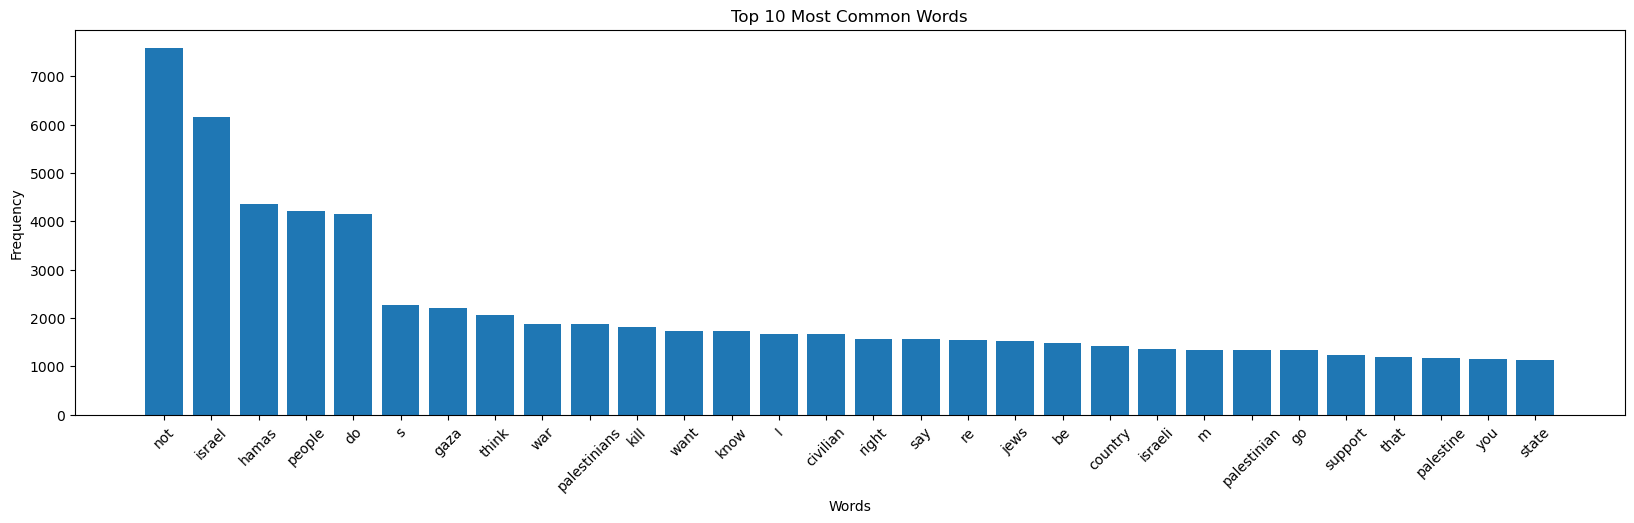

In [31]:
all_words = [word for text in df['text_wx'] for word in text.split()]
word_counts = Counter(all_words)

most_common_words = word_counts.most_common(30)
words, counts = zip(*most_common_words)

plt.figure(figsize=(20, 5))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=45)
plt.show()

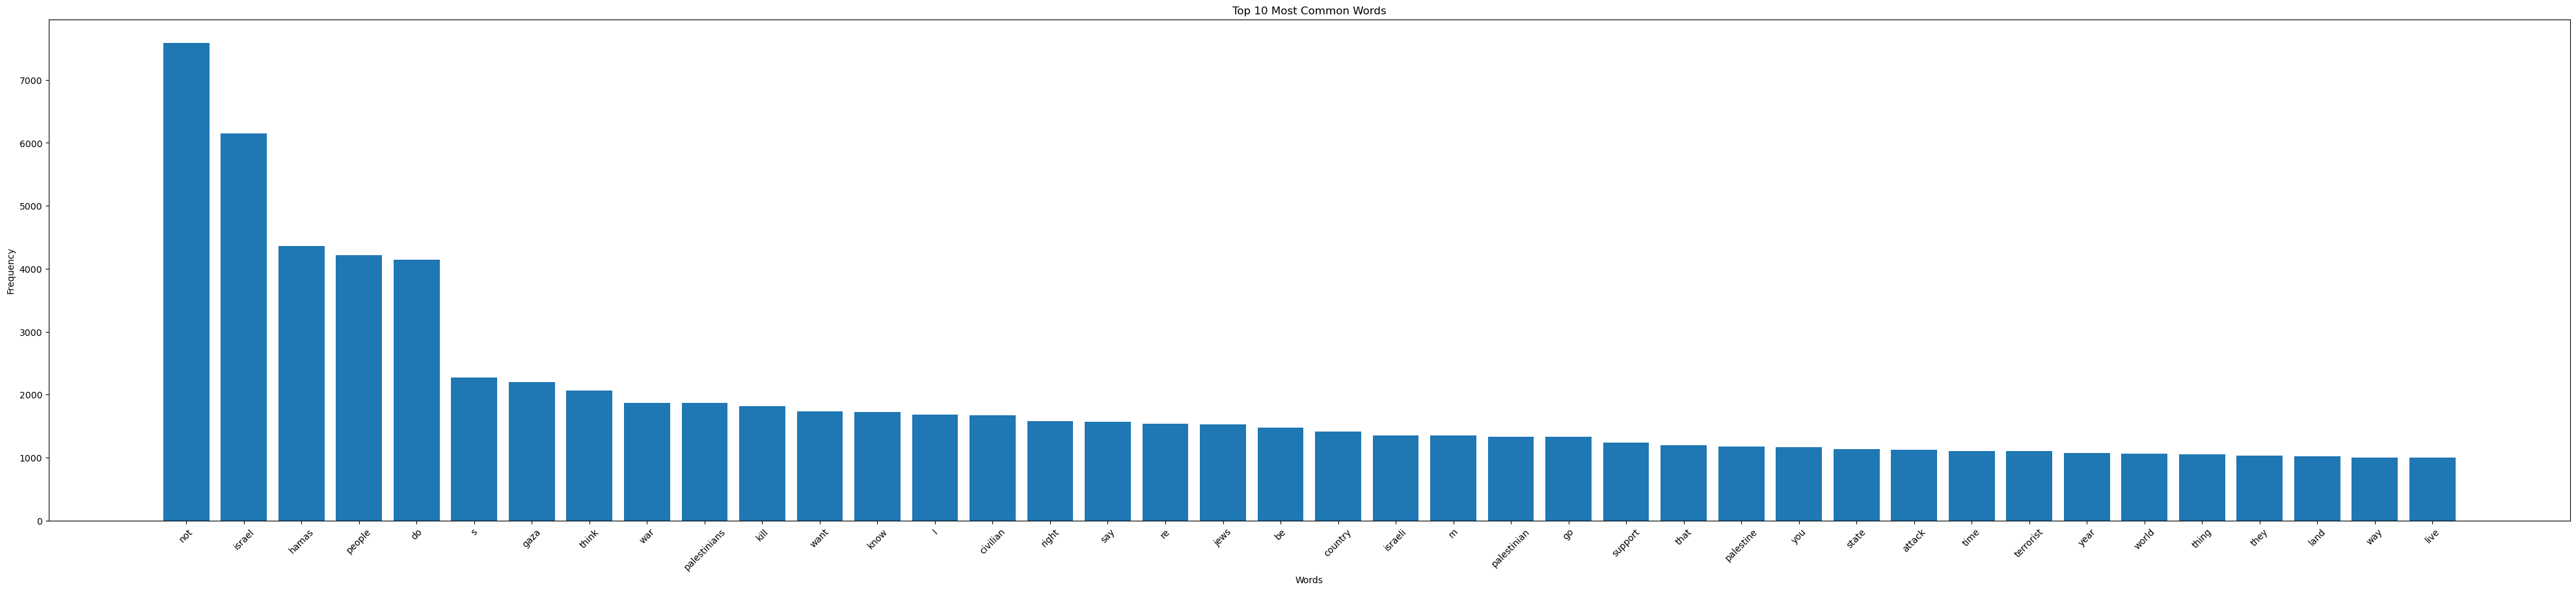

In [32]:
all_words = [word for text in df['text_wx'] for word in text.split()]
word_counts = Counter(all_words)

most_common_words = word_counts.most_common(40)
words, counts = zip(*most_common_words)

plt.figure(figsize=(50, 10))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=45)
plt.show()

## Word Cloud

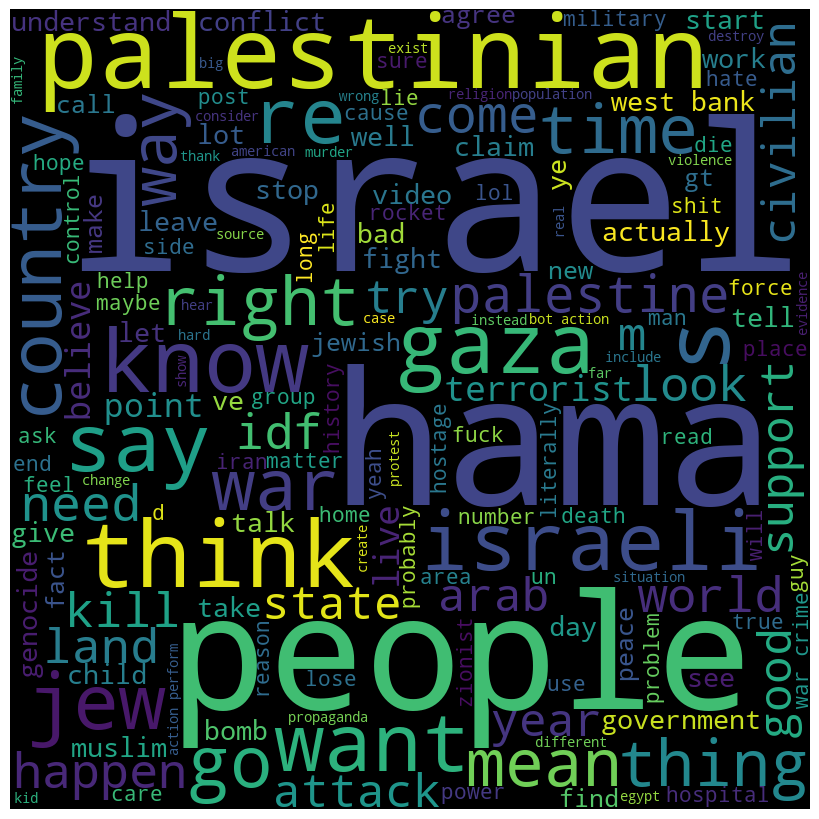

In [33]:
wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='black', 
                      min_font_size = 10).generate(text)

plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

## Comment Length

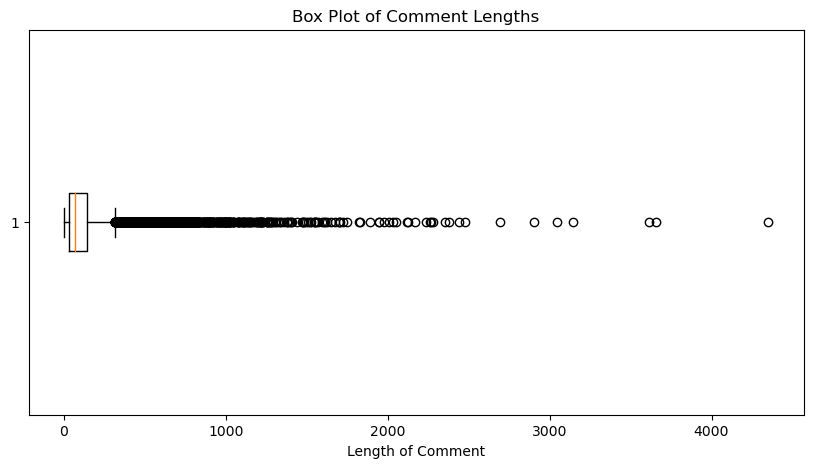

In [34]:
df['comment_length'] = df['text_wx'].str.len()

plt.figure(figsize=(10, 5))
plt.boxplot(df['comment_length'], vert=False)
plt.title('Box Plot of Comment Lengths')
plt.xlabel('Length of Comment')
plt.show()

### Removing Long Comments

In [35]:
df = df[df['comment_length'] <= 1800]

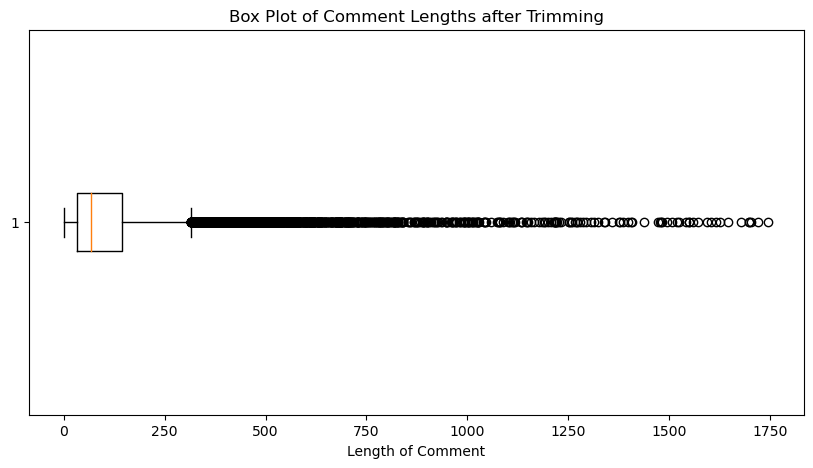

In [36]:
plt.figure(figsize=(10, 5))
plt.boxplot(df['comment_length'], vert=False)
plt.title('Box Plot of Comment Lengths after Trimming')
plt.xlabel('Length of Comment')
plt.show()

# Sentiment Analysis (lexicon-based)

In [37]:
df.sample(5)

,comment_id,score,text_wx,comment_length
62578,k8gre4q,1,israel annex part west bank withdraw rest terr...,116
5804,k4bj9tt,2,location speak eye witness,26
40125,k6pkek0,3,bibi trash idf reason level hospital great res...,61
4958,k46ola4,10,refreshing read,15
56618,k7xk1x5,0,I m befuddle russia criticize israel support h...,396


In [38]:
SIA = SentimentIntensityAnalyzer()

df['sentiment'] = df['text_wx'].apply(lambda x: SIA.polarity_scores(x))

df['sentiment_score'] = df['sentiment'].apply(lambda x: x['compound'])
df['sentiment_label'] = df['sentiment_score'].apply(lambda c: 'positive' if c > 0.05 else ('negative' if c < -0.05 else 'neutral'))

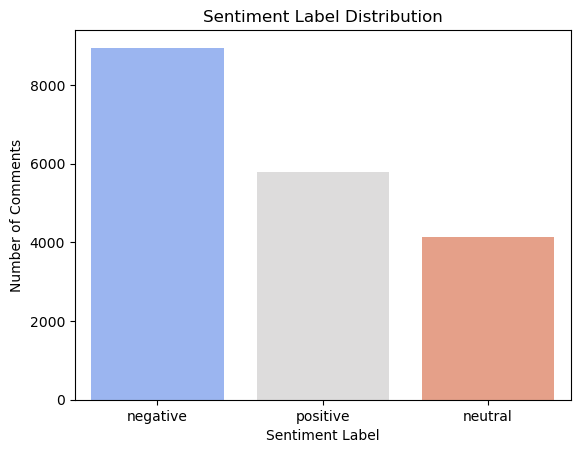

In [39]:
sentiment_counts = df['sentiment_label'].value_counts()

sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')
plt.title('Sentiment Label Distribution')
plt.ylabel('Number of Comments')
plt.xlabel('Sentiment Label')
plt.show()

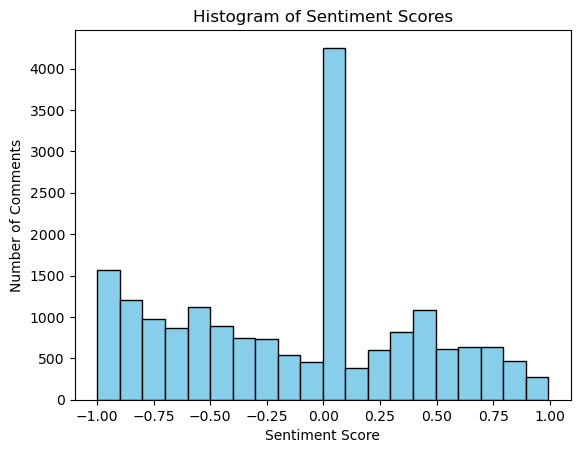

In [40]:
plt.hist(df['sentiment_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Comments')
plt.show()

#  Feature Extraction

In [41]:
df.head()

,comment_id,score,text_wx,comment_length,sentiment,sentiment_score,sentiment_label
21412,k580nkg,19,let stay hopeful nonetheless biden backtrack w...,130,"{'neg': 0.272, 'neu': 0.609, 'pos': 0.118, 'co...",-0.6486,negative
27051,k5q7ybs,29,switzerland autonomous I m sure relevant question,49,"{'neg': 0.0, 'neu': 0.635, 'pos': 0.365, 'comp...",0.3182,positive
59215,k86skte,2,good datum think datum look bombing strategy w...,204,"{'neg': 0.155, 'neu': 0.718, 'pos': 0.127, 'co...",-0.2960,negative
71451,k9fdz3d,3,arab culture child lose parent raise relative,45,"{'neg': 0.31, 'neu': 0.69, 'pos': 0.0, 'compou...",-0.4019,negative
43487,k6zy3ou,1,source talk issue concern arab they re directl...,195,"{'neg': 0.132, 'neu': 0.774, 'pos': 0.095, 'co...",-0.0772,negative


In [42]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf_features = tfidf_vectorizer.fit_transform(df['text_wx'])

# Sentiment Prediction

In [43]:
y_pred = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, y_pred, test_size=0.2, random_state=42)
    # Text Analytics - Bag of Words Feature Extraction

In [44]:
model_tfidf = MultinomialNB()
model_tfidf.fit(X_train, y_train)
sentiment_pred = model_tfidf.predict(X_test)


In [45]:
report_tfidf = classification_report(y_test, sentiment_pred, output_dict=True)

accuracy = report_tfidf['accuracy']
macro_avg = report_tfidf['macro avg']
weighted_avg = report_tfidf['weighted avg']

print(f"Accuracy: {accuracy:.2f}")
print(f"Macro Avg Precision: {macro_avg['precision']:.2f}, Recall: {macro_avg['recall']:.2f}, F1-score: {macro_avg['f1-score']:.2f}")
print(f"Weighted Avg Precision: {weighted_avg['precision']:.2f}, Recall: {weighted_avg['recall']:.2f}, F1-score: {weighted_avg['f1-score']:.2f}")

    # print(report_tfidf) couldn't print report as the output was too large

Accuracy: 0.59
Macro Avg Precision: 0.69, Recall: 0.47, F1-score: 0.44
Weighted Avg Precision: 0.66, Recall: 0.59, F1-score: 0.52


# Topic Modeling: LDA

In [47]:
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = count_vectorizer.fit_transform(df['text_wx'])

In [48]:
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [57]:
tf_feature_names = count_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx}:")
    top_words = [tf_feature_names[i] for i in topic.argsort()[-30:]]
    top_words.reverse() # Reversing order so that most important is shown first
    print(" ".join(top_words))

Topic 0:
people israel say think support right palestinians know israeli believe good want jews genocide mean happen palestine hamas palestinian wrong ask try ve way thing war attack actually let claim
Topic 1:
israel hamas gaza civilian war palestinians israeli attack terrorist palestinian west state rocket want bomb military right bank kill people target say land palestine government hospital egypt israelis try year
Topic 2:
people country jews israel land jewish think world state muslim live palestine year want arab thing come know time right war iran russia religion middle need hate ve leave happen
Topic 3:
comment post question bot action concern rule contact perform automatically moderator thank allow gt point video subredditmessagecomposetorisraelpalestine link information word sub confirm base subreddit nazi fact source report simple propaganda
Topic 4:
hamas people kill child gaza civilian israel know think idf hostage innocent want terrorist look war death time bad need way v

In [58]:
topic_results = lda_model.transform(dtm)

df['topic'] = topic_results.argmax(axis=1)

In [59]:
topic_names = {0: 'Ethics & Beliefs', 1: 'Military', 2: 'History', 3: 'Unclear Web Related', 4: 'Concern for Innocent'}

df['topic_label'] = df['topic'].map(topic_names)

In [60]:
df.head()

,comment_id,score,text_wx,comment_length,sentiment,sentiment_score,sentiment_label,topic,topic_label
21412,k580nkg,19,let stay hopeful nonetheless biden backtrack w...,130,"{'neg': 0.272, 'neu': 0.609, 'pos': 0.118, 'co...",-0.6486,negative,2,History
27051,k5q7ybs,29,switzerland autonomous I m sure relevant question,49,"{'neg': 0.0, 'neu': 0.635, 'pos': 0.365, 'comp...",0.3182,positive,0,Ethics & Beliefs
59215,k86skte,2,good datum think datum look bombing strategy w...,204,"{'neg': 0.155, 'neu': 0.718, 'pos': 0.127, 'co...",-0.2960,negative,1,Military
71451,k9fdz3d,3,arab culture child lose parent raise relative,45,"{'neg': 0.31, 'neu': 0.69, 'pos': 0.0, 'compou...",-0.4019,negative,4,Concern for Innocent
43487,k6zy3ou,1,source talk issue concern arab they re directl...,195,"{'neg': 0.132, 'neu': 0.774, 'pos': 0.095, 'co...",-0.0772,negative,2,History


In [61]:
topic_label_counts = df['topic_label'].value_counts()
print(topic_label_counts)

Concern for Innocent    5103
History                 4431
Ethics & Beliefs        4354
Military                3948
Unclear Web Related     1022
Name: topic_label, dtype: int64


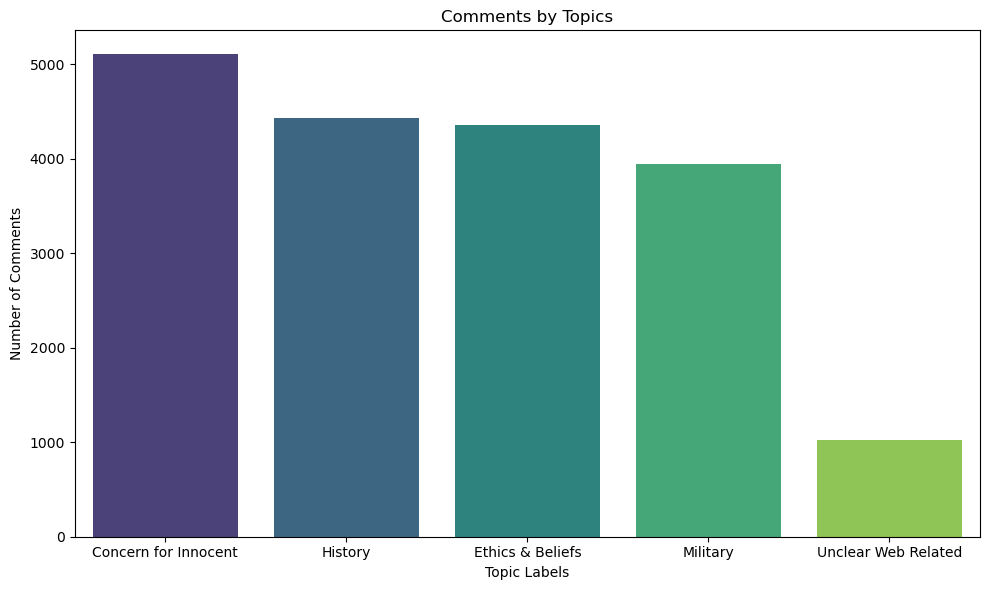

In [62]:
plt.figure(figsize=(10, 6))
sns.barplot(x=topic_label_counts.index, 
            y=topic_label_counts.values,
            palette="viridis")
plt.title('Comments by Topics')
plt.xlabel('Topic Labels')
plt.ylabel('Number of Comments')
plt.tight_layout() 
plt.show()

# Supervised Model

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf_features = tfidf_vectorizer.fit_transform(df['text_wx'])
    # Same as before

In [63]:
X = tfidf_features  
y = df['topic_label'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [66]:
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [67]:
y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))

                      precision    recall  f1-score   support

Concern for Innocent       0.67      0.68      0.67      1068
    Ethics & Beliefs       0.56      0.59      0.57       873
             History       0.64      0.60      0.62       878
            Military       0.63      0.64      0.64       757
 Unclear Web Related       0.74      0.58      0.65       196

            accuracy                           0.63      3772
           macro avg       0.65      0.62      0.63      3772
        weighted avg       0.63      0.63      0.63      3772



# Downloading Dataset for Dashboard

In [71]:
df.shape

(18858, 9)

In [75]:
df.sample(20)

,comment_id,score,text_wx,comment_length,sentiment,sentiment_score,sentiment_label,topic,topic_label
31095,k60s5kd,9,leader do not care protest post run corporatio...,304,"{'neg': 0.255, 'neu': 0.682, 'pos': 0.063, 'co...",-0.8551,negative,2,History
39070,k6qo1xo,1,yes matter division mistake learn history pale...,139,"{'neg': 0.309, 'neu': 0.461, 'pos': 0.23, 'com...",-0.5267,negative,0,Ethics & Beliefs
26480,k5iwt68,1,abu tabla character play yoni sharon israeli s...,70,"{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp...",0.3400,positive,0,Ethics & Beliefs
38003,k6lq0qw,1,read fact iran shoot woman do not wear religio...,177,"{'neg': 0.227, 'neu': 0.72, 'pos': 0.052, 'com...",-0.6499,negative,0,Ethics & Beliefs
37793,k6limgs,21,oil arm sale ally adjacent suez canal siginthu...,136,"{'neg': 0.214, 'neu': 0.672, 'pos': 0.113, 'co...",-0.3400,negative,2,History
7871,k4hheqx,2,islam terrorism fuckin shitty relegion,38,"{'neg': 0.732, 'neu': 0.268, 'pos': 0.0, 'comp...",-0.8481,negative,3,Unclear Web Related
57865,k82fapb,2,giant kalashnikov action theatergrade ak,40,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,4,Concern for Innocent
11426,k4rhf5a,3,doubt live stream tomorrow say they ll cut int...,51,"{'neg': 0.397, 'neu': 0.603, 'pos': 0.0, 'comp...",-0.5574,negative,4,Concern for Innocent
61156,k8b7x2x,2,way remember happen muslims crusader states ba...,76,"{'neg': 0.226, 'neu': 0.774, 'pos': 0.0, 'comp...",-0.5423,negative,1,Military
39590,k6oknin,48,confused fight british fishing boat whilst hal...,76,"{'neg': 0.38, 'neu': 0.62, 'pos': 0.0, 'compou...",-0.5994,negative,2,History


In [78]:
df.to_csv('C:/Users/danie/Documents/Predictive Data Analytics/Israel_Palestine_conflict_project/text_analytics_dataset.csv', index=False)
# Saving for use in Dashboard notebook